In [ ]:
# XX  XY  YX  YY

In [2]:
import csv
import sys
from casacore.tables import table
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [3]:

MSfile = '/data/users/kyle/Mishas_Data/M83'

t = table(MSfile,readonly=False)
print('\nMS: ', MSfile, '\n')
print(t.summary)

# print MS columns
print('MS tables: ', t.colnames(), '\n')


Successful read/write open of default-locked table /data/users/kyle/Mishas_Data/M83: 23 columns, 115500 rows
('\nMS: ', '/data/users/kyle/Mishas_Data/M83', '\n')
<bound method table.summary of <casacore.tables.table.table object at 0x7fb1f0f319f0>>
('MS tables: ', ['UVW', 'FLAG', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'WEIGHT_SPECTRUM'], '\n')


In [4]:
A1 = t.getcol("ANTENNA1")
A2 = t.getcol("ANTENNA2")
data = t.getcol("DATA")
ant_list = list(set(np.append(A1,A2)))
com =  np.array(list(itertools.combinations(ant_list,2)));


In [5]:
ant_list

[0, 1, 2, 3, 4, 5, 6]

In [4]:
com

array([[0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [0, 6],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [2, 3],
       [2, 4],
       [2, 5],
       [2, 6],
       [3, 4],
       [3, 5],
       [3, 6],
       [4, 5],
       [4, 6],
       [5, 6]], dtype=int32)

# Stokes Parameters
![Stokes](https://wikimedia.org/api/rest_v1/media/math/render/svg/a2a14987a593f76a3ff8179563afa8e5e3bde4ce)


In [27]:
def stokes(X,Y):
    I = np.square((np.absolute(X))) + np.square((np.absolute(Y)))
    Q = np.square((np.absolute(X))) - np.square((np.absolute(Y)))
    U = 2*((X*np.conj(Y)).real)
    V = -2*((X*np.conj(Y)).imag)
    return(I,Q,U,V)

# Creation of a feature vector n=20
4 Correlations:
    1: real
    2: imag
    3: magnitude
    4: phase
Each correlation has 4 features therefore = 16

4 Stokes parameters

In [28]:
%%time
features = np.empty([1100000,20,21])
XX = np.empty([1100000],dtype=complex)
YY =  np.empty([1100000],dtype=complex)

for i in range (0,21):
        c = 0
        for j in range (0,16,4):
            features[:,j,i] = ((data[(A1==com[i,0]) & (A2==com[i,1])][:,:,c].real)).flatten()
            features[:,j+1,i] = ((data[(A1==com[i,0]) & (A2==com[i,1])][:,:,c].imag)).flatten()
            features[:,j+2,i] = (np.abs(data[(A1==com[i,0]) & (A2==com[i,1])][:,:,c])).flatten()
            features[:,j+3,i] = (np.angle(data[(A1==com[i,0]) & (A2==com[i,1])][:,:,c])).flatten()

            #c = loop through correlations: only goes up to 4
            c = c +1
        #calculate stokes for baseline=i
        XX = ((data[(A1==com[i,0]) & (A2==com[i,1])][:,:,0])).flatten()
        YY = ((data[(A1==com[i,0]) & (A2==com[i,1])][:,:,3])).flatten()
        stokes_param = stokes(XX,YY)
        #add stokes to features vector
        d = 0
        for m in range(16,20):
            features[:,m,i] = stokes_param[d]
            d = d + 1


CPU times: user 17 s, sys: 9.79 s, total: 26.7 s
Wall time: 26.8 s


In [30]:
import h5py
with h5py.File('/data/users/kyle/Mishas_Data/M83_stokes_h5/20features.h5', 'w') as f:
#     grp = f.create_group("features")
    f.create_dataset("features", data = features)


In [31]:
for i in range(0,21):
    for j in range(0,20):
        features[:,j,i] = features[:,j,i]/np.max(features[:,j,i])

In [126]:
import h5py
with h5py.File('/data/users/kyle/Mishas_Data/M83_stokes_h5/features_norm.h5', 'w') as f:
#     grp = f.create_group("features")
    f.create_dataset("features", data = feat,dtype="float32")


# Note there are massive values in stokes

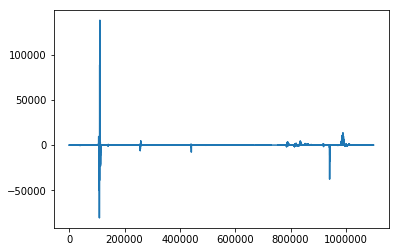

In [69]:
plt.plot(features[:,19,3])

In [83]:
import numpy as np
import h5py

with h5py.File('/data/users/kyle/Mishas_Data/M83_stokes_h5/20features.h5', 'r') as f:
    features = f['.']['features'].value


In [121]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, covariance_type = 'spherical', verbose=1)
gmm.fit(features[:,:,0])
labels = gmm.predict(features[:,:,0])


Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True


In [124]:
features[:,:,0].shape

(1100000, 20)

In [122]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, covariance_type = 'spherical', verbose=1)
gmm.fit(features[:,:,0])
labels1= gmm.predict(features[:,:,0])


Initialization 0
  Iteration 0
Initialization converged: True


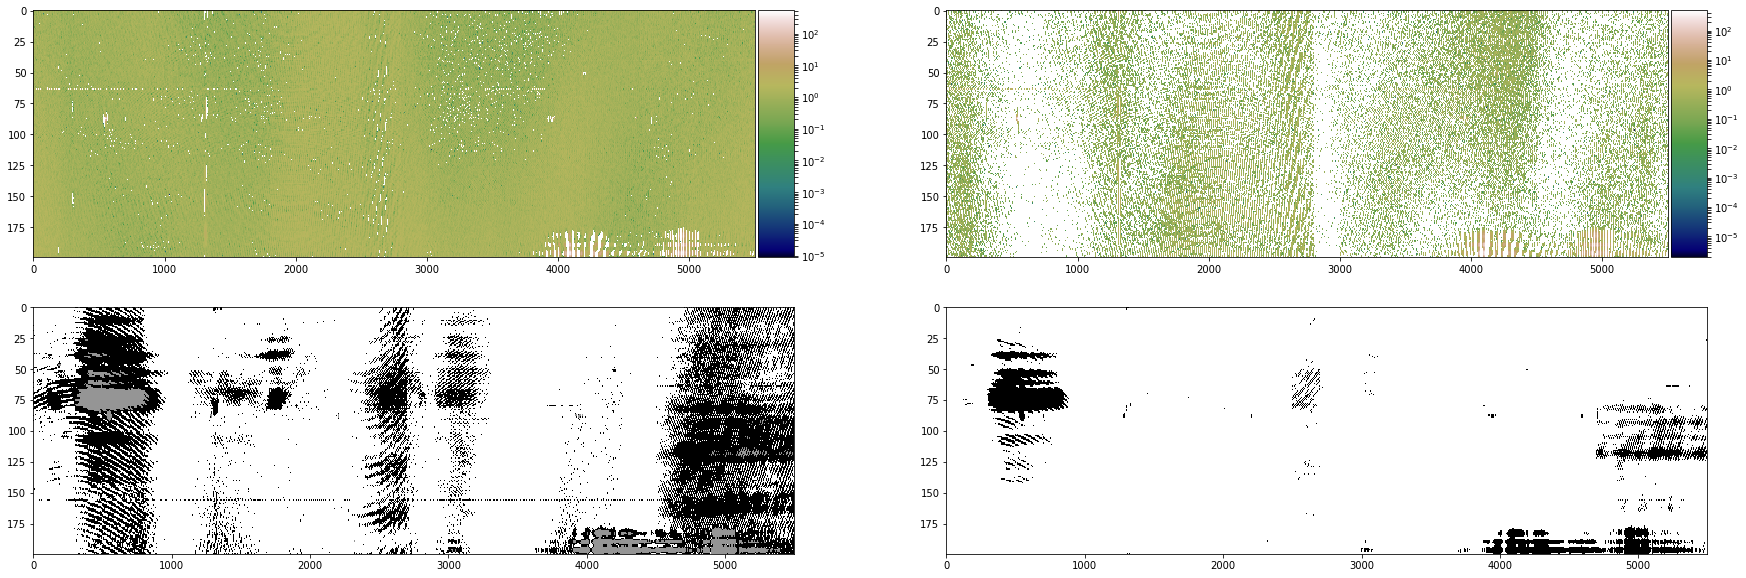

In [123]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(221)
im1 = ax1.imshow(np.transpose(features[:,0,18].reshape(5500,200)), aspect="auto", cmap="gist_earth", norm=matplotlib.colors.LogNorm())

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(np.transpose(features[:,1,18].reshape(5500,200)), aspect="auto", cmap="gist_earth", norm=matplotlib.colors.LogNorm())

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(np.transpose((labels).reshape(5500,200)), aspect="auto", cmap="Greys")

# divider = make_axes_locatable(ax3)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im3, cax=cax, orientation='vertical');

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(np.transpose((labels1).reshape(5500,200)), aspect="auto", cmap="Greys")

# divider = make_axes_locatable(ax4)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im4, cax=cax, orientation='vertical');

In [70]:
fig.savefig('/users/kyle/images/gmm_features.png', bbox_inches='tight')


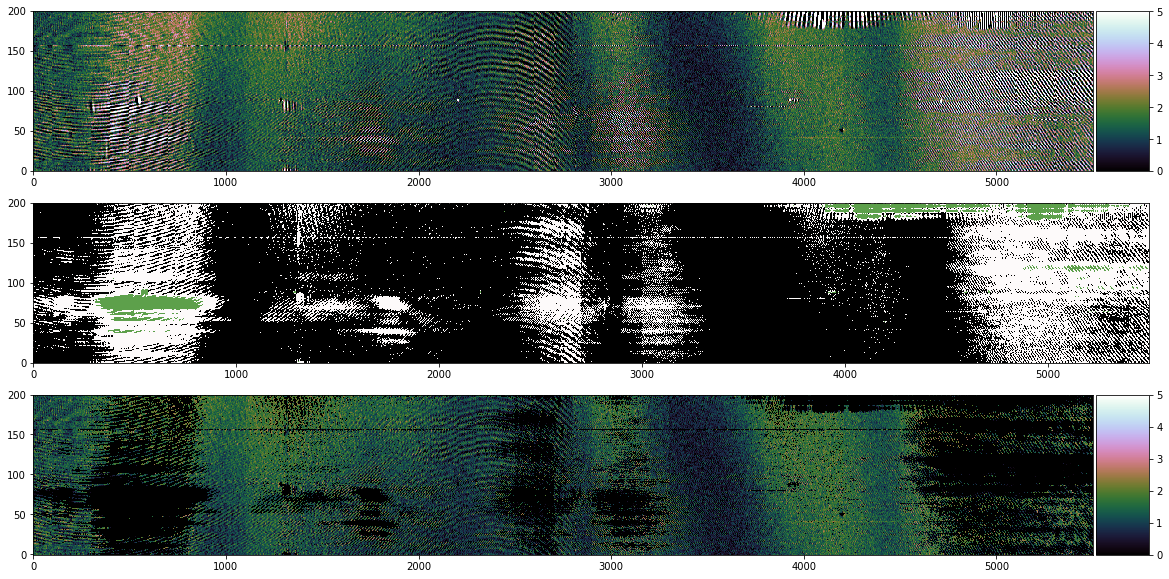

In [79]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(311)
im1 = ax1.imshow(np.transpose(features[:,0,0].reshape(5500,200)), aspect="auto", cmap="cubehelix", vmax=5,vmin=0)
plt.gca().invert_yaxis()

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax3 = fig.add_subplot(312)
im3 = ax3.imshow(np.transpose(labels.reshape(5500,200)), aspect="auto", cmap="gist_earth")
plt.gca().invert_yaxis()

ax3 = fig.add_subplot(313)
im1 = ax3.imshow(np.transpose((features[:,0,0]*(labels==0)).reshape(5500,200)), aspect="auto", cmap="cubehelix", vmax=5,vmin=0)
plt.gca().invert_yaxis()

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')



In [80]:

np.savetxt('/users/kyle/GMM_Labels.txt', (labels==0), delimiter=',')   

# PCA + KPCA

In [16]:
from sklearn.decomposition import KernelPCA
import time

start = time.time()
kpca = KernelPCA(kernel="rbf", gamma=-1e-5, n_components =2)
X_kpca = kpca.fit_transform(features[:,:,0])
total_time = (time.time() - start)
print("Time taken for KPCA: %.4f" % total_time)


MemoryError: 

In [17]:
from sklearn.decomposition import PCA
import time

start = time.time()
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(features[:,:,0])
total_time = (time.time() - start)
print("Time taken for PCA: %.4f" % total_time)

Time taken for PCA: 4.2313


In [22]:
features[:,:,0].shape

(1100000, 12)

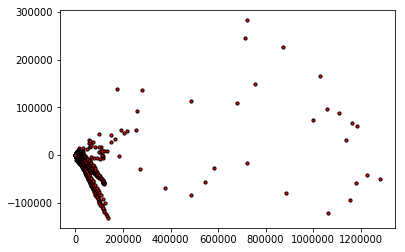

In [42]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c="red",
            s=10, edgecolor='k')
# plt.scatter(X_pca[reds, 0], X_pca[reds, 1], c="red",
#             s=10, edgecolor='k')
# # plt.scatter(X_pca[blues, 0], X_pca[blues, 1], c="blue",
# #             s=10, edgecolor='k')
plt.show()

# KMeans

In [37]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5).fit(features[:,:,0])
labels = km.predict(features[:,:,0])

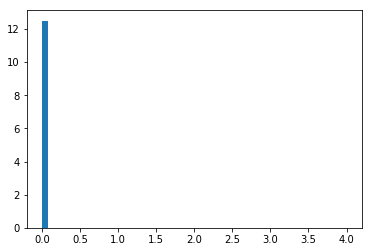

In [39]:
plt.hist(labels, 50,density=True)
plt.show()

# t-SNE

In [41]:
import time

from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=75, n_iter=1000)
tsne_results = tsne.fit_transform(features[:,:,0])
total_time = (time.time() - start)

print("Time taken for t-SNE: %.4f" % total_time)


[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 1100000 samples in 3.927s...
[t-SNE] Computed neighbors for 1100000 samples in 2870.942s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1100000
[t-SNE] Computed conditional probabilities for sample 2000 / 1100000
[t-SNE] Computed conditional probabilities for sample 3000 / 1100000
[t-SNE] Computed conditional probabilities for sample 4000 / 1100000
[t-SNE] Computed conditional probabilities for sample 5000 / 1100000
[t-SNE] Computed conditional probabilities for sample 6000 / 1100000
[t-SNE] Computed conditional probabilities for sample 7000 / 1100000
[t-SNE] Computed conditional probabilities for sample 8000 / 1100000
[t-SNE] Computed conditional probabilities for sample 9000 / 1100000
[t-SNE] Computed conditional probabilities for sample 10000 / 1100000
[t-SNE] Computed conditional probabilities for sample 11000 / 1100000
[t-SNE] Computed conditional probabilities for sample 12000 / 1100000
[t-SNE] Computed c

In [ ]:
plt.hist(tsne_results, 50,density=True)
plt.show()